# Kenya Road Signs Classifier in Keras/TensorFlow

A CNN that classifies over 43 types of road signs in the Keras framework

Dataset: 

GTSRB dataset, a dataset with over 50,000 images of German Traffic Signs. There are 43 classes (43 different types of signs that we’re going to have to classify)

https://www.kaggle.com/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign


In [1]:
# Import required libraries 
# ------------------------------------------------------------------------------------------------------------------------------

import os, cv2, random, imutils

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import classification_report
from imutils import paths

import h5py

import matplotlib.pyplot as plt

In [2]:
data_path = 'D:/AnacondaProjects/image_recognition/data/traffic_signs/Germany/'
class_names = pd.read_csv(data_path+'class_names.csv')
class_names = class_names['SignName']

img_size = 32

In [3]:
# Function to laod image data
# ------------------------------------------------------------------------------------------------------------------------------
# - randomize data to prevent model from overfitting to specific classes.

def load_data(dataset, name):
    images = []
    classes = []
    
    rows = pd.read_csv(dataset)
    rows = rows.sample(frac=1).reset_index(drop=True)
    
    for i, row in rows.iterrows():
        img_class = row["ClassId"]
        img_path = row["Path"]
        image = os.path.join(data_path, img_path) # Full image path
        
        image = cv2.imread(image)
        image_rs = cv2.resize(image, (img_size, img_size), 3) # Model training faster with images of the same dimensions
        
        # histogram equalization - equalization technique which improves the contrast in images
        R, G, B = cv2.split(image_rs)
        img_r = cv2.equalizeHist(R)
        img_g = cv2.equalizeHist(G)
        img_b = cv2.equalizeHist(B)
        
        new_image = cv2.merge((img_r, img_g, img_b))
        
        #if i % 10000 == 0:
        #    print(f"Loaded: {i}") # Print load progress after each 10K images loaded
            
        images.append(new_image)
        classes.append(img_class)
        
    X = np.array(images)
    y = np.array(classes)
    
    #Randomize the order of the input images
    s=np.arange(X.shape[0])
    np.random.seed(43)
    np.random.shuffle(s)
    X=X[s]
    y=y[s]
    
    print('[INFO]: '+name+' Data Loaded == '+str(len(X)))
    return (X, y)

In [4]:
# Load Data
# ------------------------------------------------------------------------------------------------------------------------------
%%time

train_data = data_path+'Train.csv'
test_data = data_path+'Test.csv'

(train_X, train_y) = load_data(train_data, 'Train')
(test_X, test_y) = load_data(test_data, 'Test')


[INFO]: Train Data Loaded == 39209
[INFO]: Test Data Loaded == 12630


In [5]:
# Prepare the data for training
# ------------------------------------------------------------------------------------------------------------------------------
# - normalize the data i.e. scale down the values to be between 0 and 1, from before which was between 0 and 255.
# - one-hot encode the test and train labels
# - to account for inequalities in the classes assign a weight to each class.
%%time

print('[INFO]: Normalizing data...')

train_X = train_X.astype("float32") / 255.0
test_X = test_X.astype("float32") / 255.0

print('[INFO]: One-Hot Encoding data...')

num_labels = len(np.unique(train_y))
train_y = to_categorical(train_y, num_labels)
test_y = to_categorical(test_y, num_labels)

class_totals = train_y.sum(axis=0)
class_weight = class_totals.max() / class_totals

[INFO]: Normalizing data...
[INFO]: One-Hot Encoding data...


# Building & Training the Model

In [6]:
# Define the Convolutional Newural Network Using TensorFlow Keras
# ------------------------------------------------------------------------------------------------------------------------------

class RoadSignClassifier:
    def createCNN(width, height, depth, classes):
        model = Sequential() #Sequential API allows creating the model layer-by-layer
        inputShape = (height, width, depth)
        
        model.add(Conv2D(8, (5, 5), input_shape=inputShape, activation="relu"))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        
        model.add(Conv2D(16, (3, 3), activation="relu"))
        model.add(BatchNormalization())
        model.add(Conv2D(16, (3, 3), activation="relu"))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))
 
        model.add(Conv2D(32, (3, 3), padding="same", activation="relu"))
        model.add(BatchNormalization())
        model.add(Conv2D(32, (3, 3), padding="same", activation="relu"))
        model.add(BatchNormalization())
        
        model.add(Flatten())
        model.add(Dropout(0.5))
        model.add(Dense(512, activation="relu"))
        model.add(Dense(classes, activation="softmax"))
        
        return model

In [7]:
# Train the Model
# ------------------------------------------------------------------------------------------------------------------------------
# - Use ImageDataGenerator module to perform data augmentation
# - data_aug = create modified versions of the images to add images to our dataset without us having to collect new ones.
%%time

print('[INFO]: Setting Hyperparameters...')
epochs = 50
learning_rate = 0.001 #0.001
batch_size = 32

print('[INFO]: Performing Data Augmentation...')
data_aug = ImageDataGenerator(rotation_range=10,
                              zoom_range=0.15,
                              width_shift_range=0.1,
                              height_shift_range=0.1,
                              shear_range=0.15,
                              horizontal_flip=False,
                              vertical_flip=False,
                              fill_mode='nearest')

print('[INFO]: Defining CNN Model...')
model = RoadSignClassifier.createCNN(width=32, height=32, depth=3, classes=43)
optimizer = Adam(lr=learning_rate, decay=learning_rate / (epochs*0.5))

print('[INFO]: Compiling the model...')
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

fit = model.fit(data_aug.flow(train_X, train_y, batch_size=batch_size),
                          epochs=epochs,
                          validation_data=(test_X, test_y),
                          class_weight=class_weight,
                          verbose=1)

[INFO]: Setting Hyperparameters...
[INFO]: Performing Data Augmentation...
[INFO]: Defining CNN Model...
[INFO]: Compiling the model...
Train for 1226 steps, validate on 12630 samples
Epoch 1/50
1226/1226 [==============================] - 63s 52ms/step - loss: 1.3618 - accuracy: 0.5949 - val_loss: 0.7287 - val_accuracy: 0.7717
Epoch 2/50
1226/1226 [==============================] - 63s 51ms/step - loss: 0.5390 - accuracy: 0.8267 - val_loss: 0.4535 - val_accuracy: 0.8641
Epoch 3/50
1226/1226 [==============================] - 70s 57ms/step - loss: 0.3436 - accuracy: 0.8883 - val_loss: 0.3278 - val_accuracy: 0.9019
Epoch 4/50
1226/1226 [==============================] - 63s 52ms/step - loss: 0.2592 - accuracy: 0.9157 - val_loss: 0.2288 - val_accuracy: 0.9309
Epoch 5/50
1226/1226 [==============================] - 69s 56ms/step - loss: 0.2172 - accuracy: 0.9311 - val_loss: 0.2671 - val_accuracy: 0.9160
Epoch 6/50
1226/1226 [==============================] - 66s 54ms/step - loss: 0.1862 -

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 8)         608       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 16)        1168      
_________________________________________________________________
batch_normalization (BatchNo (None, 12, 12, 16)        64        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 16)        2320      
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 10, 16)        64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 16)          0

In [9]:
# Evaluate the Model per Traffic Sign Class
# ------------------------------------------------------------------------------------------------------------------------------
%%time

print("[INFO] Evaluating Model...")

predictions = model.predict(test_X, batch_size=batch_size)
print(classification_report(test_y.argmax(axis=1),
                            predictions.argmax(axis=1), 
                            target_names=class_names))


[INFO] Evaluating Model...
                                                    precision    recall  f1-score   support

                              Speed limit (20km/h)       1.00      0.93      0.97        60
                              Speed limit (30km/h)       1.00      0.99      0.99       720
                              Speed limit (50km/h)       0.99      0.99      0.99       750
                              Speed limit (60km/h)       0.99      0.91      0.95       450
                              Speed limit (70km/h)       0.99      0.97      0.98       660
                              Speed limit (80km/h)       0.91      0.98      0.94       630
                       End of speed limit (80km/h)       1.00      0.86      0.92       150
                             Speed limit (100km/h)       0.97      0.98      0.98       450
                             Speed limit (120km/h)       0.99      0.98      0.98       450
                                        No passing  

In [10]:
# CNN Model accuracy / val_accuracy
# ------------------------------------------------------------------------------------------------------------------------------

acc = round(fit.history['accuracy'][-1]*100,2)
val_acc = round(fit.history['val_accuracy'][-1]*100,2)

print('Train Accuracy      == '+str(acc)+'%')
print('Validation Accuracy == '+str(val_acc)+'%')


Train Accuracy      == 99.12%
Validation Accuracy == 97.6%


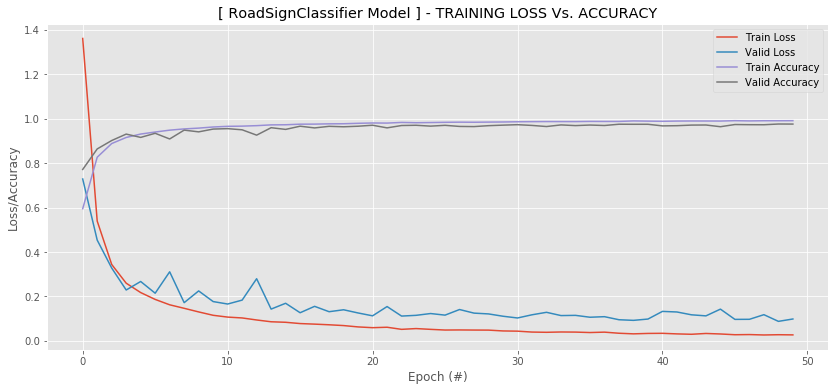

In [11]:
# plot the training loss and accuracy
# ------------------------------------------------------------------------------------------------------------------------------

N = np.arange(0, epochs)

plt.style.use("ggplot")
plt.figure(figsize=(14,6))

plt.plot(N, fit.history["loss"], label="Train Loss")
plt.plot(N, fit.history["val_loss"], label="Valid Loss")
plt.plot(N, fit.history["accuracy"], label="Train Accuracy")
plt.plot(N, fit.history["val_accuracy"], label="Valid Accuracy")

plt.title("[ RoadSignClassifier Model ] - TRAINING LOSS Vs. ACCURACY")
plt.xlabel("Epoch (#)")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")

plt.show()
#plt.savefig(args["plot"])

In [12]:
# Save the entire model to a HDF5 file.
# ------------------------------------------------------------------------------------------------------------------------------
# - The '.h5' extension indicates that the model should be saved to HDF5.

model.save('model_RoadSignClassifier.h5') 
print('[INFO]: Model SAVED!')

[INFO]: Model SAVED!


# Predicting Using the Model Saved

In [13]:
# Load saved RoadSignClassifier
# ------------------------------------------------------------------------------------------------------------------------------
%%time

print("[INFO]: Loading Pre-trained Model...")

model = load_model('model_RoadSignClassifier.h5')
 
# Get image to predict
print("[INFO]: Predicting Traffic Sign...")

img = r'Predict/60-speed-limit' #60-speed-limit.png
img_path = data_path+img+'.png'

image = cv2.imread(img_path)

image_rs = cv2.resize(image, (img_size, img_size), 3) # Model training faster with images of the same dimensions

# histogram equalization - equalization technique which improves the contrast in images
R, G, B = cv2.split(image_rs)
img_r = cv2.equalizeHist(R)
img_g = cv2.equalizeHist(G)
img_b = cv2.equalizeHist(B)

image = cv2.merge((img_r, img_g, img_b))

# preprocess the image by scaling it to the range [0, 1]
image = image.astype("float32") / 255.0
image = np.expand_dims(image, axis=0)

# make predictions using the traffic sign recognizer CNN
preds = model.predict(image)
j = preds.argmax(axis=1)[0]
label = class_names[j]
print('Predicted Label == '+label)

# load the image using OpenCV, resize it, and draw the label on it
image = cv2.imread(img_path)
image = imutils.resize(image, width=128)
cv2.putText(image, label, (5, 15), 
                cv2.FONT_HERSHEY_SIMPLEX,
                0.45, (0, 0, 255), 2)

# save the image to disk
p = data_path+img+'_PRED.png'
w = cv2.imwrite(p, image)
print('[ DONE ]')

[INFO]: Loading Pre-trained Model...
[INFO]: Predicting Traffic Sign...
Predicted Label == General caution
[ DONE ]
